<a href="https://colab.research.google.com/github/axel-sirota/implement-nlp-word-embedding/blob/main/module4/Module4_Demo2_Word_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U gensim

     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Analysing Sentiment

Let's first import everything and load the dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
%%writefile get_data.sh
if [ ! -f glove.6B.zip ]; then
  wget -O glove.6B.zip https://nlp.stanford.edu/data/glove.6B.zip
  unzip glove.6B.zip
fi

Writing get_data.sh


In [ ]:
!bash get_data.sh


--2022-05-26 21:34:14--  https://raw.githubusercontent.com/axel-sirota/implement-nlp-word-embedding/main/module3/data/yelp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8091185 (7.7M) [text/plain]
Saving to: ‘yelp.csv’

yelp.csv            100%[===================>]   7.72M  --.-KB/s    in 0.1s    

2022-05-26 21:34:16 (72.2 MB/s) - ‘yelp.csv’ saved [8091185/8091185]

--2022-05-26 21:34:16--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-26 21:34:17--  http://downlo

## Load GloVe weights and model

In [8]:
# convert glove to word2vec format
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.50d.txt", word2vec_output_file="emb_word2vec_format.txt")

(400000, 50)

In [9]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('emb_word2vec_format.txt')

In [10]:
vocab_size_glove = len(model.index_to_key)
vocab_size_glove

400000

In [11]:
from sklearn.manifold import TSNE
print(model.most_similar('memory'))

[('personal', 0.7328489422798157), ('physical', 0.705132782459259), ('computer', 0.6909387707710266), ('hardware', 0.6837906837463379), ('memories', 0.6793382167816162), ('image', 0.6788511872291565), ('device', 0.6740666031837463), ('virtual', 0.6709290146827698), ('computers', 0.6703341603279114), ('flash', 0.6644526720046997)]


In [26]:
vocab = set()
categories = ['sports', 'politics', 'economy', 'digits', 'love', 'policewoman', 'equality']
for word_category in categories:
    words_and_scores = model.most_similar(word_category, topn=20)
    for word, score in words_and_scores:
      vocab.add(word)


In [27]:
X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


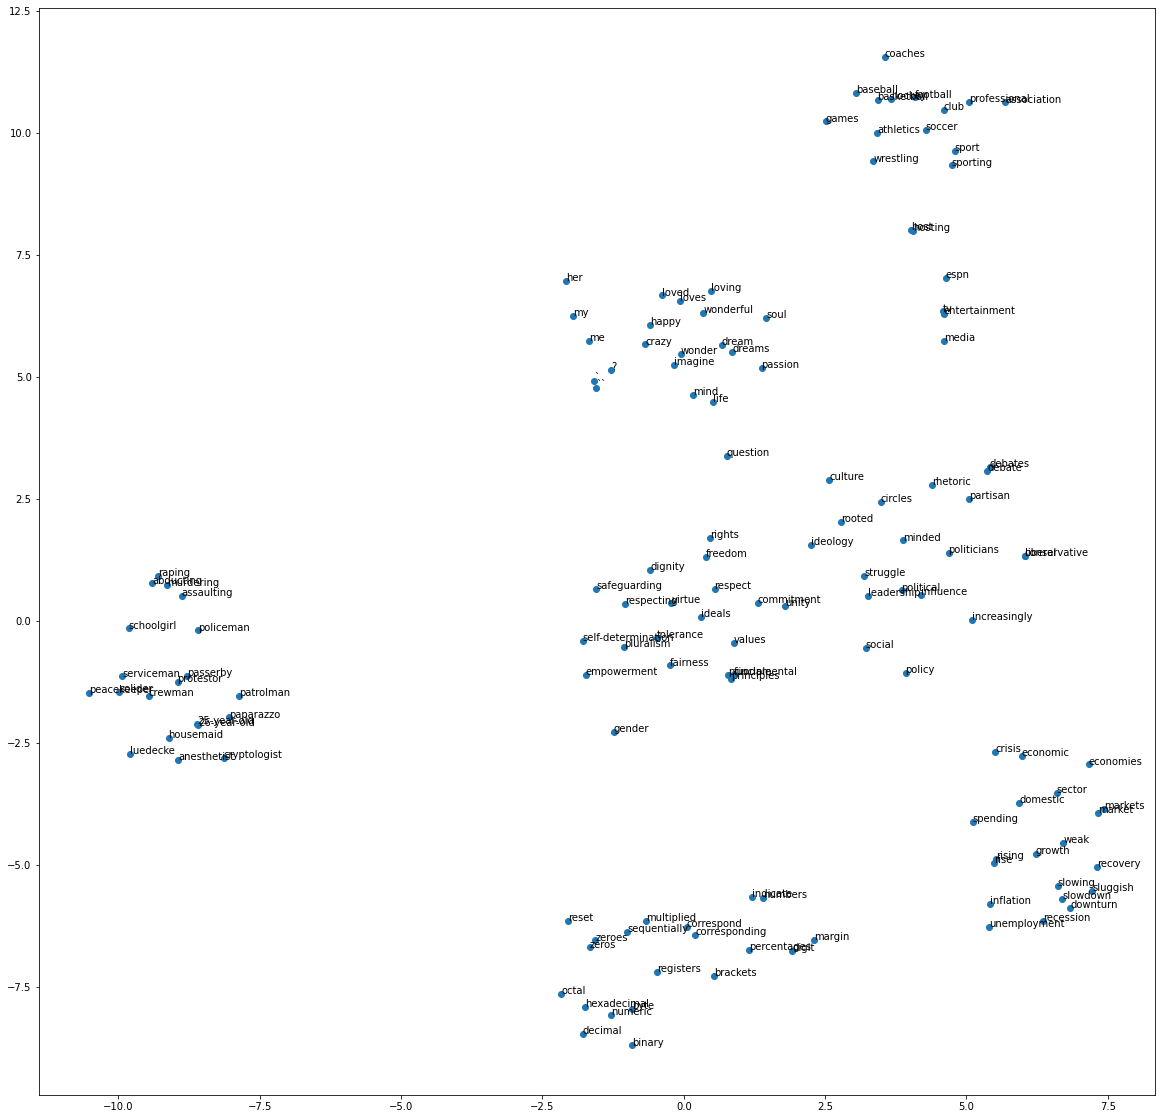

In [28]:

plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
for i, txt in enumerate(vocab):
    ax.annotate(txt, (X_tsne[:, 0][i], X_tsne[:, 1][i]))

plt.show()

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(init="random", n_clusters=len(categories), n_init=4, random_state=0)
kmeans.fit(X_tsne.astype('double'))

KMeans(init='random', n_clusters=7, n_init=4, random_state=0)

AttributeError: ignored

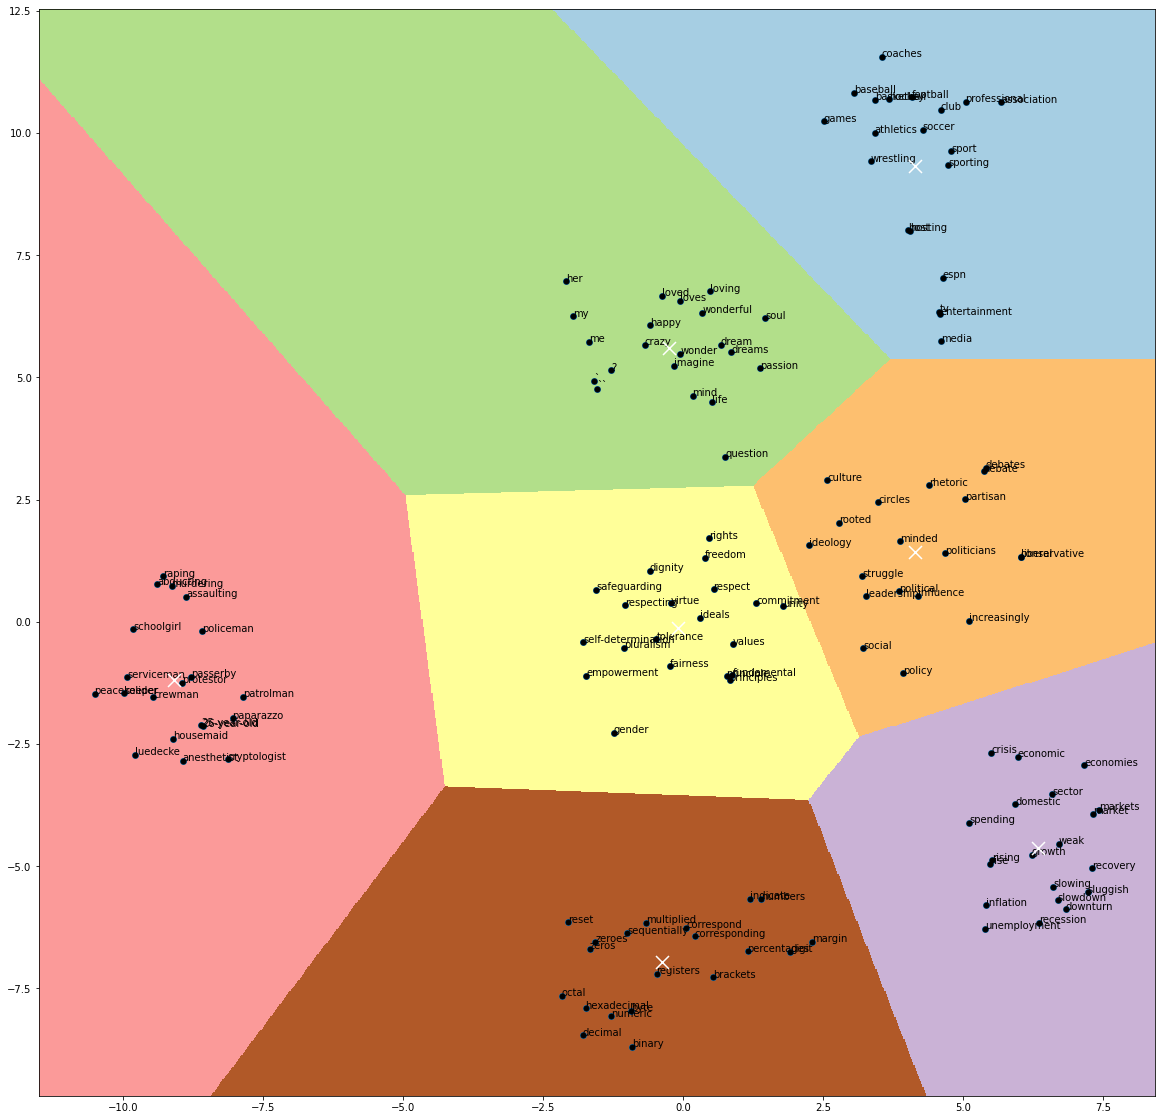

In [40]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()].astype('double'))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
# ax.clf()
ax.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

ax.plot(X_tsne[:, 0], X_tsne[:, 1], "k.", markersize=10)
for i, txt in enumerate(vocab):
    ax.annotate(txt, (X_tsne[:, 0][i], X_tsne[:, 1][i]))
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
ax.xlim(x_min, x_max)
ax.ylim(y_min, y_max)
ax.xticks(())
ax.yticks(())
plt.show()

In [41]:
def analogy(worda, wordb, wordc):
    result = model.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

In [42]:
analogy('fly', 'plane', 'sail')

'aboard'

In [43]:
analogy('cat', 'kitten', 'dog')

'puppy'

In [44]:
analogy('man', 'woman', 'doctor')

'nurse'